In [1]:
# import necessary libraries
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import requests
from io import StringIO
import cv2
# preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
# import datasets 
train_labels = pd.read_csv("datasets/train_labels.csv", delimiter=",", header=0, index_col=0)
train_images = np.load("datasets/train_images.npy", encoding="latin1")
test_images = np.load("datasets/train_images.npy", encoding="latin1")

In [3]:
# store copies, may wish to retrieve original datasets
copy_train_labels = np.copy(train_labels)
copy_train_images = np.copy(train_images)
copy_test_images = np.copy(test_images)
 
# restore original datasets
def restore():
    train_labels = np.copy(copy_train_labels)
    train_images = np.copy(copy_train_images)
    test_images = np.copy(copy_test_images)
    return train_labels, train_images, test_images

In [4]:
# check shape
print(train_labels.shape)
print(train_images.shape)
print(test_images.shape)

(10000, 1)
(10000, 2)
(10000, 2)


In [5]:
# RUN FROM FROM HERE IF DATASETS NEED TO BE RESTORED
train_labels, train_images, test_images = restore()

In [6]:
# reshape labels to 1d array, encode labels to integers
train_labels = np.array(train_labels).reshape(-1)
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_y = le.transform(train_labels)

In [7]:
# check labels
print(train_labels)
print(train_y)

['shovel' 'rifle' 'scorpion' ..., 'rollerskates' 'mouth' 'pencil']
[25 20 23 ..., 21  3 13]


In [8]:
# reshape images
train_x = []
for i in train_images[:,1]:
    train_x.append(i.reshape(100,100))
train_x = np.array(train_x, dtype=float) 

In [9]:
# check shape
print(train_x.shape)

(10000, 100, 100)


# Noise Reduction

In [10]:
def preprocessing0(dataset):
    output = []
    for i in range(len(dataset)):
        temp = dataset[i]
        temp[temp < 240] = 0
        temp[temp >= 240] = 255
        output.append(temp)
    return np.array(output)

In [11]:
p0_train_x = preprocessing0(train_x)

pineapple


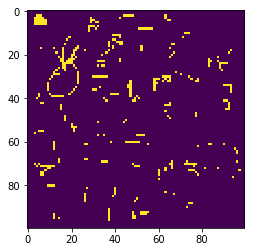

In [16]:
print(train_labels[67])
plt.imshow(train_x[67])
plt.show()

paintbrush


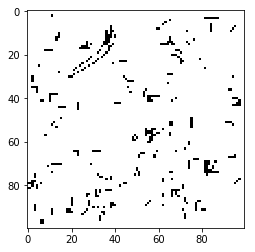

In [24]:
print(train_labels[83])
plt.imshow(p0_train_x[83], cmap='gray_r')
plt.show()

In [17]:
def preprocessing1a(dataset):
    output = []
    for j in range(len(dataset)):
        thresh = cv2.threshold(dataset[j], 240, 255, cv2.THRESH_BINARY)[1]
        img, cnts, heir = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        area_list = []
        for c in cnts:
            (x_i, y_i, w, h) = cv2.boundingRect(c)
            temp_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
            squareDim = np.max(temp_roi.shape)
            area_list.append(squareDim**2)
        idx = area_list.index(max(area_list)) 
        (x_i, y_i, w, h) = cv2.boundingRect(cnts[idx])
        new_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
        temp = dataset[j] 
        temp[temp > -1] = 0  
        temp[((100-new_roi.shape[0])//2):(((100-new_roi.shape[0])//2)+new_roi.shape[0]), ((100-new_roi.shape[1])//2):(((100-new_roi.shape[1])//2)+new_roi.shape[1])] = new_roi
        output.append(temp)
    return output

In [18]:
p1a_train_x = preprocessing1a(train_x)

pineapple


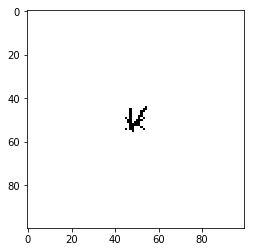

In [19]:
print(train_labels[67])
plt.imshow(p1a_train_x[67], cmap='gray_r')
plt.show()

In [ ]:
def preprocessing1b(dataset):
    output = []
    for j in range(len(dataset)):
        thresh = cv2.threshold(dataset[j], 240, 255, cv2.THRESH_BINARY)[1]
        img, cnts, heir = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        area_list = []
        for c in cnts:
            (x_i, y_i, w, h) = cv2.boundingRect(c)
            temp_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
            squareDim = np.max(temp_roi.shape)
            area_list.append(squareDim**2)
        idx = area_list.index(max(area_list)) 
        ii = np.where(area_list == max(area_list))[0]
        if len(ii) > 1:
            smallestContourArea = cv2.boundingRect(cnts[ii[0]])
            sca_idx = ii[0]
            for i in range(1,len(ii)):
                if smallestContourArea > cv2.boundingRect(cnts[ii[i]]):
                    smallestContourArea = cv2.boundingRect(cnts[ii[i]])
                    sca_idx = ii[i]
            idx = sca_idx
        (x_i, y_i, w, h) = cv2.boundingRect(cnts[idx])
        new_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
        temp = dataset[j] 
        temp[temp > -1] = 0  
        temp[((100-new_roi.shape[0])//2):(((100-new_roi.shape[0])//2)+new_roi.shape[0]), ((100-new_roi.shape[1])//2):(((100-new_roi.shape[1])//2)+new_roi.shape[1])] = new_roi
        output.append(temp)
    return output

In [ ]:
p1b_train_x = preprocessing1b(train_x)

In [ ]:
print(train_labels[67])
plt.imshow(p1b_train_x[67], cmap='gray_r')
plt.show()

In [ ]:
def deskew(img):
    SZ=100
    affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

In [ ]:
def preprocessing2a(dataset):
    output = []
    for j in range(len(dataset)):
        thresh = cv2.threshold(dataset[j], 251, 255, cv2.THRESH_BINARY)[1]
        img, cnts, heir = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        area_list = []
        for c in cnts:
            (x_i, y_i, w, h) = cv2.boundingRect(c)
            temp_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
            squareDim = np.max(temp_roi.shape)
            area_list.append(squareDim**2)
        idx = area_list.index(max(area_list)) 
        ii = np.where(area_list == max(area_list))[0]
        if len(ii) > 1:
            smallestContourArea = cv2.boundingRect(cnts[ii[0]])
            sca_idx = ii[0]
            for i in range(1,len(ii)):
                if smallestContourArea > cv2.boundingRect(cnts[ii[i]]):
                    smallestContourArea = cv2.boundingRect(cnts[ii[i]])
                    sca_idx = ii[i]
            idx = sca_idx
        (x_i, y_i, w, h) = cv2.boundingRect(cnts[idx])
        new_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
        temp = dataset[j] 
        temp[temp > -1] = 0  
        temp[((100-new_roi.shape[0])//2):(((100-new_roi.shape[0])//2)+new_roi.shape[0]), ((100-new_roi.shape[1])//2):(((100-new_roi.shape[1])//2)+new_roi.shape[1])] = new_roi
        coords = np.column_stack(np.where(temp > 0))
        angle = cv2.minAreaRect(coords)[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle
        # rotate the image to deskew it
        (h, w) = temp.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(temp, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        final = deskew(rotated)
        output.append(final)
    return output

In [ ]:
p2a_train_x = preprocessing2a(train_x)

In [ ]:
print(train_labels[67])
plt.imshow(p2a_train_x[67], cmap='gray_r')
plt.show()

In [ ]:
def preprocessing2b(dataset):
    output = []
    for j in range(len(dataset)):
        thresh = cv2.threshold(dataset[j], 251, 255, cv2.THRESH_BINARY)[1]
        img, cnts, heir = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        area_list = []
        for c in cnts:
            (x_i, y_i, w, h) = cv2.boundingRect(c)
            temp_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
            squareDim = np.max(temp_roi.shape)
            area_list.append(squareDim**2)
        idx = area_list.index(max(area_list)) 
        ii = np.where(area_list == max(area_list))[0]
        if len(ii) > 1:
            smallestContourArea = cv2.boundingRect(cnts[ii[0]])
            sca_idx = ii[0]
            for i in range(1,len(ii)):
                if smallestContourArea > cv2.boundingRect(cnts[ii[i]]):
                    smallestContourArea = cv2.boundingRect(cnts[ii[i]])
                    sca_idx = ii[i]
            idx = sca_idx
        (x_i, y_i, w, h) = cv2.boundingRect(cnts[idx])
        new_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
        temp = dataset[j] 
        temp[temp > -1] = 0  
        temp[((100-new_roi.shape[0])//2):(((100-new_roi.shape[0])//2)+new_roi.shape[0]), ((100-new_roi.shape[1])//2):(((100-new_roi.shape[1])//2)+new_roi.shape[1])] = new_roi     
        angles = np.linspace(-45, 45, num=91).astype(int)
        rotate_area_list = [] 
        for i in range(len(angles)):
            rotateTest = temp
            (h, w) = rotateTest.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angles[i], 1.0)
            rotated = cv2.warpAffine(temp, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
            img, cnts, heir = cv2.findContours(rotated.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cnt_w = []
            for c in cnts:
                (x_i, y_i, w, h) = cv2.boundingRect(c)
                cnt_w.append(w)
            rotate_area_list.append(max(cnt_w))
        rotate_idx = rotate_area_list.index(min(rotate_area_list))
        (h, w) = temp.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angles[rotate_idx], 1.0)
        rotated = cv2.warpAffine(temp, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        final = deskew(rotated)
        output.append(final)
        #print(j)
    return output

In [ ]:
p2b_train_x = preprocessing2b(train_x)

In [ ]:
print(train_labels[67])
plt.imshow(p2b_train_x[67], cmap='gray_r')
plt.show()

In [ ]:
def preprocessing2c(dataset):
    output = []
    for j in range(len(dataset)):
        thresh = cv2.threshold(dataset[j], 251, 255, cv2.THRESH_BINARY)[1]
        img, cnts, heir = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        area_list = []
        #temp2 = dataset[j]
        temp2 = np.zeros((100,100))
        bestAng = []
        for c in cnts:
            (x_i, y_i, w, h) = cv2.boundingRect(c)
            temp_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
            temp2[temp2 > -1] = 0 
            temp2[((100-temp_roi.shape[0])//2):(((100-temp_roi.shape[0])//2)+temp_roi.shape[0]), ((100-temp_roi.shape[1])//2):(((100-temp_roi.shape[1])//2)+temp_roi.shape[1])] = temp_roi
            angles = np.linspace(-45, 45, num=91).astype(int)
            rotate_w, rotate_h = [], []
            for i in range(len(angles)):
                rotateTest = temp2
                (h, w) = rotateTest.shape[:2]
                center = (w // 2, h // 2)
                M = cv2.getRotationMatrix2D(center, angles[i], 1.0)
                rotated = cv2.warpAffine(rotateTest, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
                img2, cnts2, heir2 = cv2.findContours(rotated.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                cnt_w = []
                cnt_h = []
                for c1 in cnts2:
                    (x_i, y_i, w, h) = cv2.boundingRect(c1)
                    cnt_w.append(w)
                    cnt_h.append(h)
                rotate_w.append(max(cnt_w))
                rotate_h.append(cnt_h[cnt_w.index(max(cnt_w))])          
            rotate_idx = rotate_w.index(min(rotate_w))
            minW = rotate_w[rotate_idx]
            hFromMinW = rotate_h[rotate_idx]
            squareDim = max(minW, hFromMinW)
            area_list.append(squareDim**2)
            bestAng.append(angles[rotate_idx])
        idx = area_list.index(max(area_list))
        ii = np.where(area_list == max(area_list))[0]
        (x_i, y_i, w, h) = cv2.boundingRect(cnts[idx])
        new_roi = thresh[y_i:(y_i+h), x_i:(x_i+w)]
        temp = np.zeros((100,100))
        temp[temp > -1] = 0  
        temp[((100-new_roi.shape[0])//2):(((100-new_roi.shape[0])//2)+new_roi.shape[0]), ((100-new_roi.shape[1])//2):(((100-new_roi.shape[1])//2)+new_roi.shape[1])] = new_roi
        angles = np.linspace(-45, 45, num=91).astype(int)
        rotate_area_list = []
        (h, w) = temp.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, bestAng[idx], 1.0)
        rotated = cv2.warpAffine(temp, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        final = deskew(rotated)
        output.append(final)
        print(j)
    return output

In [ ]:
p2c_train_x = preprocessing2c(train_x)

In [ ]:
print(train_labels[67])
plt.imshow(p2c_train_x[67], cmap='gray_r')
plt.show()

### ANOTHER ATTEMPT

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

In [14]:
# reshape train_x (10000*10000) i.e. 10000 rows with 10000 pixels each
train_x2 = []
for i in train_images[:,1]:
    train_x2.append(np.array(i))
train_x2 = np.array(train_x2, dtype=float)

MemoryError: 

In [ ]:
cov_mat = np.cov(train_x2.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort()
eig_pairs.reverse()